In [1]:
# Simple RNN-LSTM regression
# 2017-03-16 jkang
# Python3.5
# Tensorflow1.0.1
#
# input: one sinewave
# output: one sinewave (one sample shifted)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Input, Ouput dataset
duration = 10  # sec
srate = 100  # Hz
freq = .5  # Hz
amplitude = np.random.random(1) * 10
t = np.linspace(0, duration, duration * srate + 1)
sin = np.sin(2 * np.pi * freq * t) * amplitude
shift = 10
sin_in = sin[:-shift]
sin_out = sin[shift:]  # shifting

# Hyper-Parameters
learning_rate = 0.01
max_iter = 20

# Network Parameters
n_input_dim = 1
n_input_len = len(sin_in)
n_output_len = len(sin_out)
n_hidden = 50
n_output_dim = 1

# TensorFlow graph
# (batch_size) x (time_step) x (input_dimension)
x = tf.placeholder(tf.float32, [1, n_input_len, n_input_dim])
# (batch_size) x (time_step) x (output_dimension)
y = tf.placeholder(tf.float32, [1, n_output_len, n_output_dim])

# Parameters
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_output_dim]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_output_dim]))
}

In [3]:
def RNN(inputs, weights, biases):
    # Reshape to (time_step) x (batch_size) x (input_dimension)
    inputs = tf.transpose(inputs, [1, 0, 2])
    # Reshape to (time_step)*(batch_size) x (input_dimension)
    inputs = tf.reshape(inputs, [-1, n_input_dim])
    # Split to get a list of time_step tensors of shape (batch_size, input_dimension)
    # final 'inputs' is a list of n_input_len elements (=number of frames)
    inputs = tf.split(value=inputs, num_or_size_splits=n_input_len, axis=0)

    lstm = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    outputs, states = tf.nn.dynamic_rnn(lstm, x, dtype=tf.float32)
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)
cost = tf.reduce_mean(tf.squared_difference(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [ ]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step <= max_iter:
        train_x = sin_in.reshape((1, n_input_len, n_input_dim))
        train_y = sin_out.reshape((1, n_output_len, n_output_dim))
        c, _ = sess.run([cost, optimizer], feed_dict={x: train_x, y: train_y})
        print('Epoch =', str(step), '/', str(max_iter),
              'Cost = ', '{:.5f}'.format(c))
        step += 1

    # Test
    pred_out = sess.run(pred, feed_dict={x: train_x})

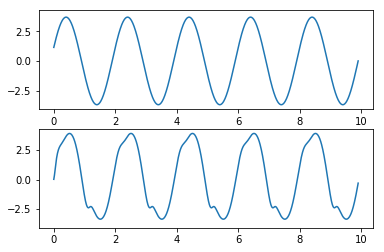

In [12]:
# Plot
f, axes = plt.subplots(2, sharey=True)
axes[0].plot(t[:-shift], sin_out)
axes[1].plot(t[:-shift], pred_out)
plt.show()